# **01 Visualise phase assemblages**
---

This notebook shows you how to:
1. Call theriak from python with pytheriak.
2. Retrieve system parameters, mineral modes and compostion from the pytheriak.Rock-object.
3. Visualise petrological data with python.🐍

**Requirements:**
- python >= 3.10
*with the following packages installed:*
- pytheriak
- matplotlib
- ...

*Theriak-Domino back-end:*
- A working Theriak-Domino installation.
- Thermodynamic databases to use with Theriak in the working directory.
---

### Import all required libraries.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytheriak import wrapper

### Initiate a TherCaller-object.
The argument `programs_dir` must be set to the directory of your Theriak_Domino installation.

In [3]:
theriak = wrapper.TherCaller(programs_dir="C:\\TheriakDominoWIN\\Programs",
                             database="ds55HPT.txt",
                             theriak_version="v28.05.2022")

In [4]:
pressure = 8000
temperature = 550
bulk = "SI(68.2)TI(0.76)AL(25.18)FE(9.96)MN(0.02)MG(4.36)CA(0.18)NA(0.06)K(7.74)H(100)O(?)"

In [5]:
rock, element_list = theriak.minimisation(pressure, temperature, bulk)

In [6]:
mineral_names = [mineral.name for mineral in rock.mineral_assemblage]
mineral_modes = [mineral.vol_percent for mineral in rock.mineral_assemblage]

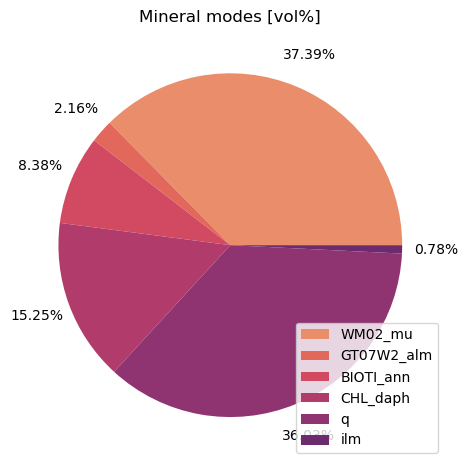

In [61]:
fig, ax = plt.subplots()

colors = sns.color_palette("flare")[0:len(mineral_modes)]

ax.pie(mineral_modes,
       #labels=mineral_names,
       autopct="%.2f%%",
       pctdistance=1.2,
       colors=colors)

ax.legend(labels=mineral_names)

ax.set_aspect("equal")

ax.set_title("Mineral modes [vol%]")

fig.tight_layout()
plt.show()

In [8]:
mineral_composition = np.array([mineral.composition_moles for mineral in rock.mineral_assemblage])
bulk_composition = np.array(rock.bulk_composition_moles)
mineral_composition_rel = mineral_composition / bulk_composition

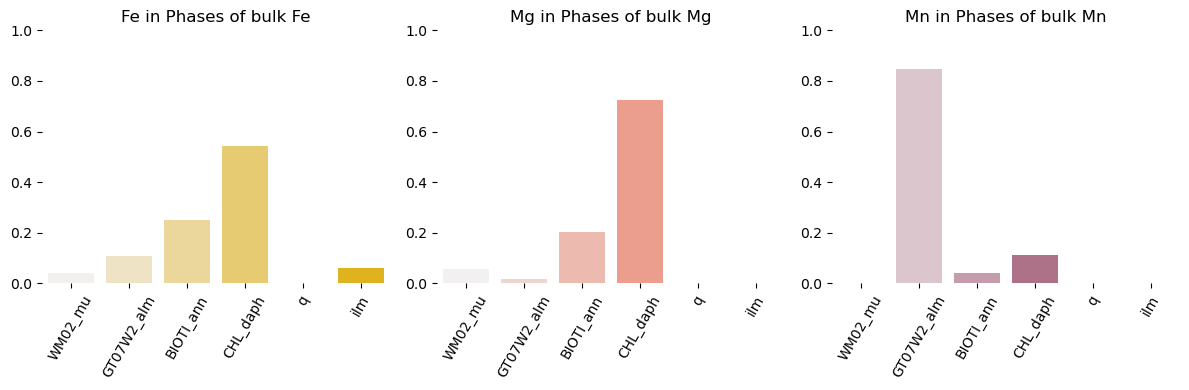

In [42]:
fe = mineral_composition_rel.T[element_list.index("FE")]
mg = mineral_composition_rel.T[element_list.index("MG")]
mn = mineral_composition_rel.T[element_list.index("MN")]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].tick_params(axis='x', rotation=60)
axs[0].set_frame_on(False)
axs[0].set_ylim(0, 1)
axs[0]. set_title("Fe in Phases of bulk Fe")
sns.barplot(x=mineral_names, y=fe, ax=axs[0], palette=sns.color_palette("light:#FFC300"))

axs[1].tick_params(axis='x', rotation=60)
axs[1].set_frame_on(False)
axs[1].set_ylim(0, 1)
axs[1]. set_title("Mg in Phases of bulk Mg")
sns.barplot(x=mineral_names, y=mg, ax=axs[1], palette=sns.color_palette("light:#FF5733"))

axs[2].tick_params(axis='x', rotation=60)
axs[2].set_frame_on(False)
axs[2].set_ylim(0, 1)
axs[2]. set_title("Mn in Phases of bulk Mn")
sns.barplot(x=mineral_names, y=mn, ax=axs[2], palette=sns.color_palette("light:#900C3F"))

fig.tight_layout()
plt.show()

In [10]:
rock.bulk_composition_mol_percent

[53.001715,
 5.467139,
 0.039082,
 2.162538,
 21.712226,
 1.680526,
 0.004342,
 0.946653,
 0.013027,
 14.807738,
 0.165013]

In [11]:
rock.mineral_assemblage[5].name

'ilm'